In [2]:
import itertools
import importlib
from functools import reduce, partial
import operator

import pennylane as qml
from pennylane import numpy as np
import numpy as nnp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import tensorflow as tf
import torch
torch.set_default_dtype(torch.float32)
mps_device = torch.device("mps")
torch.set_default_device(mps_device)
from torchinfo import summary

from silence_tensorflow import silence_tensorflow
# tf.keras.backend.set_floatx('bfloat32')

In [3]:
# import warnings
# import traceback

# warnings.simplefilter("error")
# warnings.simplefilter("once", category=qml.PennyLaneDeprecationWarning)

In [4]:
from src.layers import *

In [5]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(42)
# tf.random.set_seed(SEED)

# Data Generation

In [6]:
def generate_dataset_4(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical horizontal left diagonal or right diagonal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.25:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(0)  # Label for vertical line
        elif np.random.rand() < 0.5:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1)
        elif np.random.rand() < 0.75:
            # Left diagonal line
            for j in range(size):
                image[j, j] = 255
            labels.append(2)
        else:
            # Right diagonal line
            for j in range(size):
                image[j, size - j - 1] = 255
            labels.append(3)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    labels = np.array(labels)
    labels = np.eye(4)[labels]
    return np.array(images), np.array(labels)

def generate_dataset_2(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical or horizontal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.5:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(-1.0)  # Label for vertical line
        else:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1.0)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    # labels = np.array(labels)
    # labels = np.eye(2)[labels]
    return nnp.array(images), nnp.array(labels).astype(nnp.float32)

In [7]:
images, labels = generate_dataset_2(150, noise=0.15)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)
test_labels.dtype

dtype('float32')

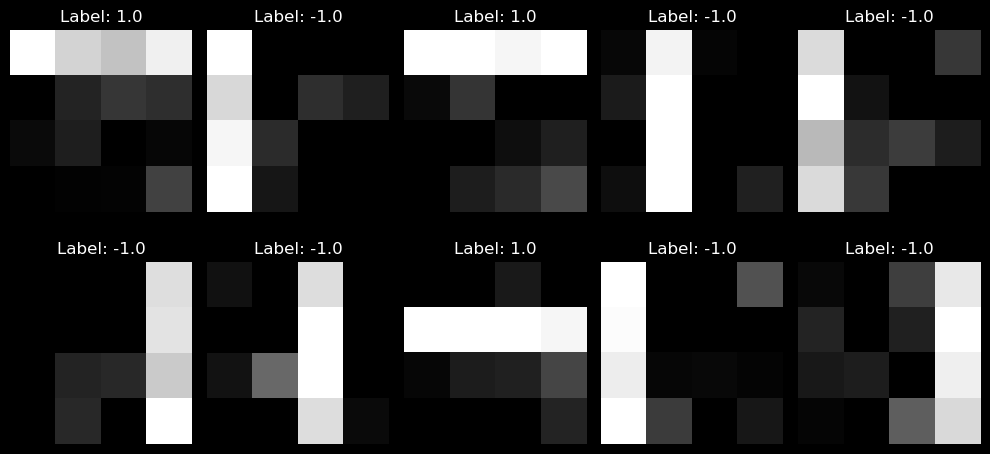

In [8]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(int(train_images.shape[1]), int(train_images.shape[2])), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
train_images, test_images = nnp.array([hots_to_sv(img.flatten()) for img in train_images]), nnp.array([hots_to_sv(img.flatten()) for img in test_images])

In [10]:
train_images, train_labels = torch.tensor(train_images, requires_grad=False), torch.tensor(train_labels, requires_grad=False)
test_images, test_labels = torch.tensor(test_images, requires_grad=False), torch.tensor(test_labels, requires_grad=False)
train_images.dtype, train_images.device, train_images.shape

/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  return func(*args, **kwargs)


(torch.complex64, device(type='mps', index=0), torch.Size([105, 65536]))

# Creating Circuit

In [11]:
assert train_images.shape[1] ** 0.5 % 1 == 0, "The input image size must be a perfect square"
B = 4
N = 4
dev = qml.device("default.qubit", wires=N**2 + B)
wire_arr = nnp.arange(N**2, dtype=nnp.int32).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 2 # two was working pretty well
STRIDE = 1

In [12]:
# @partial(qml.batch_input, argnums=0) # this is really broken (need to file a pennylane issue)
@partial(qml.batch_input, argnum=0)
@qml.qnode(dev, interface='torch')
def qnode(inputs, 
          first_kernel, first_pooling, 
          second_kernel, second_pooling, 
          # fc_weights, fc_bias
):
    # Input Layer
    # for i, j in itertools.product(range(N), range(N)):
    #     qml.RX(1.0 * np.pi * inputs[i, j], wires=wire_arr[i, j])
    qml.StatePrep(inputs, wires=wire_arr.flatten(), validate_norm=False)
    
    # First Convolution Layer    
    convolution_pooling_op(first_kernel, first_pooling, wire_arr, STRIDE)
    reduced_wire_arr = wire_arr[1::2, 1::2]
    
    # Second Convolution Layer
    convolution_pooling_op(second_kernel, second_pooling, reduced_wire_arr, STRIDE)
    reduced_wire_arr = reduced_wire_arr[1::2, 1::2]
    
    # Fully Connected Layer
    # fully_connected_op(fc_weights, fc_bias, reduced_wire_arr.flatten().tolist(), list(range(N*N, N*N + B)))
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in reduced_wire_arr.flatten().tolist()]
    # return [qml.probs(i) for i in reduced_wire_arr.flatten().tolist()]

In [13]:
weight_shapes = {
    "first_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "first_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    "second_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "second_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    # "fc_weights": (B - 1, B),
    # "fc_bias": (B,),
}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
{name: (reduce(operator.mul, x.shape), x.shape) for name, x in qlayer.qnode_weights.items()}, qlayer

({'first_kernel': (8, torch.Size([2, 2, 2])),
  'first_pooling': (4, torch.Size([2, 2])),
  'second_kernel': (8, torch.Size([2, 2, 2])),
  'second_pooling': (4, torch.Size([2, 2]))},
 <Quantum Torch Layer: func=qnode>)

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(N, N)),
#     qlayer,
#     # tf.keras.layers.Lambda(prob_extraction),
# ])
# model.load_weights('line_model.keras')
model = torch.nn.Sequential(
    qlayer,
    # torch.nn.Lambda(prob_extraction),
)
print(model(train_images[:3])) 
summary(model, input_data=train_images[0:3, :], device=mps_device)

: 

In [ ]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1)
# model.compile(opt, loss="MSE", metrics=[custom_accuracy])
# model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patched_keras_layer             │ (None, 1)              │            24 │
│ (PatchedKerasLayer)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Test the forward pass with a batch of training images
sample_output = model(train_images[:3])  # Pass the first 3 training images
print("Sample output shape:", sample_output.shape)
print("Sample output:", sample_output.numpy(), train_labels[:5])

Sample output shape: (1, 3)
Sample output: [[-0.00144401 -0.01028002 -0.00207941]] tf.Tensor([ 1. -1.  1. -1. -1.], shape=(5,), dtype=float32)


# Model Training

In [23]:
silence_tensorflow("ERROR")
fitting = model.fit(train_images, train_labels, epochs=2, batch_size=3, validation_data=(test_images, test_labels), verbose=1, shuffle=True)

Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - custom_accuracy: 0.7559 - loss: 0.9868 - val_custom_accuracy: 0.7778 - val_loss: 0.9849
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - custom_accuracy: 0.8296 - loss: 0.9796 - val_custom_accuracy: 0.7778 - val_loss: 0.9781


In [24]:
model.get_weights()[0]

array([[[-0.13181174,  0.5958044 ],
        [ 0.660317  , -0.32894802]],

       [[-0.30643484,  0.5864112 ],
        [ 0.64486796,  0.477182  ]]], dtype=float32)

In [25]:
model.save("models/line_model.keras")

# A Classical Model

In [26]:
classic_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N, 1)),
    tf.keras.layers.Conv2D(2, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.SeparableConv2D(1, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.AveragePooling2D(pool_size=KERNEL_SIZE),
    tf.keras.layers.Conv2D(2, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.SeparableConv2D(1, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.AveragePooling2D(pool_size=KERNEL_SIZE),
    
    tf.keras.layers.Flatten(),
    
    # tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    # tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    # tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    # tf.keras.layers.Dense(1, use_bias=True, activation='sigmoid'),
    
    
    tf.keras.layers.Activation('sigmoid'),
])
classic_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 2)        │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 4, 4, 1)        │            11 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 2, 2, 1)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 2)        │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 2, 2, 1)        │            11 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 1, 1)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42 (168.00 B)

 Trainable params: 42 (168.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
classic_labels = tf.where(train_labels > 0.5, 1.0, 0.0)
classic_test_labels = tf.where(test_labels > 0.5, 1.0, 0.0)
# classic_model(train_images[..., np.newaxis])

In [28]:
classic_opt = tf.keras.optimizers.Adagrad(learning_rate=0.025)
classic_model.compile(classic_opt, loss="CrossEntropy", metrics=["accuracy"])

In [29]:
fitting = classic_model.fit(train_images, classic_labels, epochs=100, batch_size=16, validation_data=(test_images, classic_test_labels), verbose=0)

In [30]:
val_loss, val_acc = classic_model.evaluate(test_images, classic_test_labels, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6380 - loss: 0.6926


# A Better Classical Model

In [15]:
classic_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N)),
    # tf.keras.layers.Conv2D(4, kernel_size=4, strides=STRIDE, use_bias=True, padding='SAME'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    tf.keras.layers.Dense(1, use_bias=True, activation='sigmoid'),
])
classic_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
classic_labels = tf.where(train_labels > 0.5, 1.0, 0.0)
classic_test_labels = tf.where(test_labels > 0.5, 1.0, 0.0)
# classic_model(train_images[..., np.newaxis])

In [17]:
classic_opt = tf.keras.optimizers.Adagrad(learning_rate=0.025)
classic_model.compile(classic_opt, loss="CrossEntropy", metrics=["accuracy"])

In [18]:
fitting = classic_model.fit(train_images, classic_labels, epochs=100, batch_size=4, validation_data=(test_images, classic_test_labels), verbose=1)

Epoch 1/100


2025-05-17 17:42:32.315206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3340 - loss: 0.7280 - val_accuracy: 0.5111 - val_loss: 0.7058
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4772 - loss: 0.7039 - val_accuracy: 0.4444 - val_loss: 0.7115
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5282 - loss: 0.6986 - val_accuracy: 0.4222 - val_loss: 0.7119
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5467 - loss: 0.6976 - val_accuracy: 0.4000 - val_loss: 0.7140
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5517 - loss: 0.6971 - val_accuracy: 0.3111 - val_loss: 0.7156
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4844 - loss: 0.6977 - val_accuracy: 0.3111 - val_loss: 0.7168
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5029 - loss: 0.6992 - val_accuracy: 0.4222 - val_loss: 0.7186
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5325 - loss: 0.7009 - val_accuracy: 0.4444 - val_loss:

In [ ]:
val_loss, val_acc = classic_model.evaluate(test_images, classic_test_labels, verbose=1)